# Bigram Frequency Comparison 

Comparing co-occurrence frequencies of 
1. bigram baseline  $=\{$`RBXadj`$\}$ 
2. directly negated bigrams $=\{$`RBdirect`$\}$
3. and the difference between these sets  $=\{$`RBXadj`$\} - \{$`RBdirect`$\}$

In [16]:
from pathlib import Path
import pandas as pd
import re
import matplotlib.pyplot as plt
from source.analyze.count_bigrams import describe_counts
from utils import print_iter, print_md_table, transform_counts

In [17]:
FREQ_OUT = Path('/share/compling/projects/sanpi/results/freq_out')
N_FILES = 35
THR_DEC_STR = '001'

## Define Helper Functions

In [123]:
def heatmap(df, columns=None, save_name=None, size=(8, 10)):

    plt.figure(figsize=size, dpi=120, facecolor="white")

    adv_labels = df.index
    if columns:
        df = df.loc[:, columns]
    df = df.astype('float')
    # Displaying dataframe as an heatmap
    # with diverging colourmap as RdYlBu
    plt.imshow(df, cmap="plasma")
    # plt.imshow(df, cmap="gist_rainbow")
    # plt.imshow(df, cmap="jet")
    # plt.imshow(df, cmap="viridis")
    # plt.autoscale(enable=True, axis='both')
    # Displaying a color bar to understand
    # which color represents which range of data
    plt.colorbar()
    # Assigning labels of x-axis
    # according to dataframe
    plt.xticks(range(len(df.columns)), df.columns, rotation=-20)
    # Assigning labels of y-axis
    # according to dataframe
    plt.yticks(range(len(df.index)), adv_labels)
    # Displaying the figure
    plt.show()


def corners(df, size: int = 5):
    index_name = df.index.name or 'frequencies'
    columns_name = df.columns.name or 'categories'
    df = df.reset_index().reset_index().set_index(
        ['index', index_name])
    df = df.T.reset_index().reset_index().set_index(
        ['index', columns_name]).T
    cdf = pd.concat(
        [dfs.iloc[:, :size].assign(__='...')
         .join(dfs.iloc[:, -size:])
         for dfs in (df.head(size).T.assign(__='...').T,
                     df.tail(size))])
    cdf = cdf.reset_index().set_index(index_name)
    cdf.pop('index')
    cdf = cdf.T.reset_index().set_index(columns_name)
    cdf.pop('index')
    return cdf.T.rename(columns={'': '...'}, index={'': '...'})


In [149]:
def sample_counts(frq_table, label,
                  rows=pd.Series(dtype='string'),
                  columns=pd.Series(dtype='string')):
    # color = 'Set1'
    # color = 'gist_rainbow'
    color = "nipy_spectral_r"
    s = frq_table.copy()
    if not any(rows): 
        s = s[s.index != 'SUM']
        s = s.iloc[5:int(frq_table.shape[0]*0.4), :] if len(s.index) >= 80 else s
        rows = s.sample(min(len(s), 16)).index
    if not any(columns): 
        s = s.loc[:, s.columns != 'SUM']
        s = s.iloc[:, 5:int(frq_table.shape[1]*0.4)] if len(s.columns) > 50 else s
        columns = s.T.sample(min(len(s.T), 8)).index
    sample_df = s.loc[rows, columns]
    # print(sample_df.describe().T.round(2).to_markdown())
    # fig = plt.figure(figsize=(6, 8), dpi=300)
    fig = plt.figure(dpi=130)
    # ax.barh(s20x10, width=1)
    sample_df.plot(kind='barh',
                   width=0.8,
                   figsize=(8, 10),
                   position=1,
                   title=f'{label} of sample',
                   grid=True,
                   colormap=color,
                   # colormap="gist_rainbow",
                   # colormap="rainbow",
                   #  colormap="brg",
                   #   colormap="nipy_spectral_r",
                   #    colormap="Set1",
                   ax=plt.gca())
    plt.show()
    fig = plt.figure(dpi=150)
    sample_df.plot(kind='barh',
                   stacked=True,
                   width=0.8,
                   figsize=(8, 10),
                   position=1,
                   title=label,
                   grid=True,
                   colormap=color,
                   # colormap="gist_rainbow",
                   #  colormap="brg",
                   #    colormap="nipy_spectral_r",
                   #    colormap="Set1",
                   ax=plt.gca()
                   )
    plt.show()
    heatmap(sample_df, size=(8, 10))
    # print(sample_df.round().to_markdown(floatfmt=',.0f'))

    return s, sample_df

In [19]:
def locate_freq_tables():
    meta_tag = f'thr0-{THR_DEC_STR}p.{N_FILES}f'
    print('# Comparing Bigram Frequencies\n',
        f'- for `{N_FILES}` corpus input `.conll` directories containing source `.conllu` files', 
        f'- with word types limited to only those that account for at least $0.{THR_DEC_STR}\%$ of the cleaned dataset (as sourced from {N_FILES} corpus file inputs) ', 
        f'- file identifier = `{meta_tag}`',
        sep='\n')
    neg_frq_pkl = FREQ_OUT.joinpath(
        f'RBdirect/all-frq_adj-x-adv_{meta_tag}.pkl.gz')
    if not neg_frq_pkl.is_file():
        print('⚠️ Path to directly negated bigrams frequency table not found.')
    try: 
        all_frq_pkl = list(FREQ_OUT.joinpath('RBXadj').glob(
            f'all_adj-x-adv_frq-{meta_tag}*.pkl.gz'))[0]
    except IndexError: 
        print('⚠️ Path to all bigrams frequency table not found.')

    global_count_floor = re.search(r'=(\d+)\+', all_frq_pkl.stem).groups()[0]
    print(
        '- pattern matches restricted to only token word types with',
        f'at least `{global_count_floor}` total tokens across all combinations')
    return all_frq_pkl, neg_frq_pkl

## Locate Starting Frequency Data

In [20]:
all_frq_pkl, neg_frq_pkl = locate_freq_tables()

# Comparing Bigram Frequencies

- for `35` corpus input `.conll` directories containing source `.conllu` files
- with word types limited to only those that account for at least $0.001\%$ of the cleaned dataset (as sourced from 35 corpus file inputs) 
- file identifier = `thr0-001p.35f`
- pattern matches restricted to only token word types with at least `868` total tokens across all combinations


# Comparing Bigram Frequencies

- for `35` corpus input `.conll` directories containing source `.conllu` files
- with word types limited to only those that account for at least $0.001\%$ of the cleaned dataset (as sourced from 35 corpus file inputs) 
- file identifier = `thr0-001p.35f`
- pattern matches restricted to only token word types with at least `868` total tokens across all combinations

## _Negated_ Frequencies Overview

In [21]:
neg_only = pd.read_pickle(neg_frq_pkl)

In [22]:
# describe_counts(df=neg_only, df_path=neg_frq_pkl)

### Full Table Preview of _Negated_ Frequencies

In [23]:
corners(neg_only, 4)

adv_form_lower,SUM,as,so,too,...,wondrously,seductively,fewer,unseasonably
adj_form_lower,,,,,,,,,
SUM,3151853,527495,341379,308112,...,1,1,1,1
good,132519,44998,18026,3631,...,0,0,0,0
sure,128813,715,26602,8101,...,0,0,0,0
bad,105249,27766,21376,19532,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
immigrant,1,0,0,0,...,0,0,0,0
later,1,0,0,0,...,0,0,0,0
menial,1,0,0,0,...,0,0,0,0
trusted,1,0,0,0,...,0,0,0,0


## _All_ (negated and non-negated) Frequencies Overview

In [24]:
all_frq = pd.read_pickle(all_frq_pkl)
# describe_counts(all_frq, all_frq_pkl)

### Full Table Preview of _All_ Frequencies

In [25]:
corners(all_frq, 4)

adv_form_lower,SUM,very,more,most,...,emphatically,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,,,
SUM,83284343,9913432,9320997,7568812,...,872,869,869,868
many,2210387,21237,373,140,...,3,0,0,0
important,2199447,359610,306604,748533,...,2,105,9,0
good,2030480,507499,18902,5207,...,6,0,7,0
...,...,...,...,...,...,...,...,...,...
carnal,872,34,150,62,...,0,0,0,0
contiguous,871,4,106,8,...,0,0,0,0
panicked,871,54,159,31,...,0,0,0,0
oversized,870,32,45,16,...,0,0,0,0


### Adjust the shapes

There are some bigrams that never occur with a direct negation, so the shapes of the loaded tables are different.
Add additional cells to `neg_only` for these missing forms (with values of `0`) to give the tables the same shape.

In [26]:
neg_only.shape

(3887, 1002)

In [27]:
all_frq.shape

(3895, 1006)

In [28]:
all(neg_only.isin(all_frq))

True

In [29]:
neg_frq = neg_only.copy().reindex_like(all_frq).fillna(0)
neg_frq.shape

(3895, 1006)

In [30]:
all(all_frq.isin(neg_frq))

True

### ⚠️ #HACK manual override

Some negation hits are double-dipping in the bigram set, when at best, this "double negation" type of set up is just **1** negated pattern match,
or it is not one at all, in the case of logical cancellation. 

Thus all `neg_frq` values will be capped at the corresponding `all_frq` value.

In [31]:
any(neg_frq > all_frq)

True

In [32]:
neg_frq.isna().apply(any).value_counts()

False    1006
dtype: int64

In [33]:
neg_frq.columns.to_series().apply(lambda c: any(neg_frq[c] > all_frq[c])).value_counts()

False    978
True      28
Name: adv_form_lower, dtype: int64

In [34]:
neg_gtr = neg_frq.copy()
neg_gtr = neg_gtr.mask(neg_frq > all_frq)
neg_gtr.isna().apply(any).value_counts()


False    978
True      28
dtype: int64

In [35]:
neg_gtr.columns.to_series().apply(lambda c: any(neg_gtr[c] > all_frq[c])).value_counts()

False    1006
Name: adv_form_lower, dtype: int64

In [36]:
neg_gtr.update(all_frq, overwrite=False)
neg_gtr.isna().apply(any).value_counts()

False    1006
dtype: int64

In [37]:
neg_gtr.columns.to_series().apply(lambda c: any(neg_gtr[c] > all_frq[c])).value_counts()

False    1006
Name: adv_form_lower, dtype: int64

In [178]:
neg_frq = neg_gtr.apply(pd.to_numeric, downcast='unsigned')


In [81]:
updated_neg_pkl = neg_frq_pkl.with_name(neg_frq_pkl.name.replace('all-frq', 'ALL-WORDS'))
print(f"negation frequency table with updated indexing as {updated_neg_pkl}")
neg_frq.to_pickle(updated_neg_pkl)

negation frequency table with updated indexing as /share/compling/projects/sanpi/results/freq_out/RBdirect/ALL-WORDS_adj-x-adv_thr0-001p.35f.pkl.gz


### Words with 0 tokens in the `RBdirect` results


In [44]:
print(all_frq.loc[~neg_frq.index.isin(neg_only.index), 'SUM'].to_markdown(floatfmt=',.0f'))


| adj_form_lower   |   SUM |
|:-----------------|------:|
| evolving         | 3,141 |
| earliest         | 2,199 |
| northerly        | 1,890 |
| southerly        | 1,426 |
| chopped          | 1,293 |
| away             | 1,291 |
| marrow           | 1,168 |
| worldwide        |   963 |



| adj_form_lower   |   SUM |
|:-----------------|------:|
| evolving         | 3,141 |
| earliest         | 2,199 |
| northerly        | 1,890 |
| southerly        | 1,426 |
| chopped          | 1,293 |
| away             | 1,291 |
| marrow           | 1,168 |
| worldwide        |   963 |

In [45]:
print(all_frq.loc['SUM', ~neg_frq.columns.isin(neg_only.columns)].to_markdown(floatfmt=',.0f'))

| adv_form_lower   |   SUM |
|:-----------------|------:|
| yearly           | 2,218 |
| sparsely         | 1,281 |
| legendarily      |   981 |
| second-most      |   869 |


| adv_form_lower   |   SUM |
|:-----------------|------:|
| yearly           | 2,218 |
| sparsely         | 1,281 |
| legendarily      |   981 |
| second-most      |   869 |

## The Difference

### $frequencies_{all} - frequencies_{neg}$

#### ➡️ potentially _not negated_ 

#### ➡️ positive polarity candidates

In [82]:
# calculate the difference
frq_diff = (all_frq - neg_frq)
print(corners(frq_diff, 3).to_markdown())
frq_diff.info()

| adj_form_lower   | SUM      | very    | more    | ...   | second-most   | cosmetically   | pointedly   |
|:-----------------|:---------|:--------|:--------|:------|:--------------|:---------------|:------------|
| SUM              | 80132490 | 9722137 | 9154690 | ...   | 869           | 815            | 853         |
| many             | 2196233  | 19311   | 371     | ...   | 0             | 0              | 0           |
| important        | 2149474  | 357748  | 291386  | ...   | 105           | 9              | 0           |
| ...              | ...      | ...     | ...     | ...   | ...           | ...            | ...         |
| contiguous       | 814      | 3       | 106     | ...   | 0             | 0              | 0           |
| panicked         | 832      | 53      | 153     | ...   | 0             | 0              | 0           |
| oversized        | 854      | 32      | 45      | ...   | 0             | 0              | 0           |
<class 'pandas.core.frame.DataFrame'>

In [83]:

# now tweak it a bit for memory optimization and improved legibility
frq_diff = (frq_diff#.fillna(0)
          .apply(pd.to_numeric, downcast='unsigned')
          .sort_values('SUM', axis=0, ascending=False)
          .sort_values('SUM', ascending=False))
print(corners(frq_diff, 3).to_markdown(floatfmt=',.0f'))
frq_diff.info()

| adj_form_lower   | SUM      | very    | more    | ...   | second-most   | cosmetically   | pointedly   |
|:-----------------|:---------|:--------|:--------|:------|:--------------|:---------------|:------------|
| SUM              | 80132490 | 9722137 | 9154690 | ...   | 869           | 815            | 853         |
| many             | 2196233  | 19311   | 371     | ...   | 0             | 0              | 0           |
| important        | 2149474  | 357748  | 291386  | ...   | 105           | 9              | 0           |
| ...              | ...      | ...     | ...     | ...   | ...           | ...            | ...         |
| spry             | 818      | 48      | 80      | ...   | 0             | 0              | 0           |
| contiguous       | 814      | 3       | 106     | ...   | 0             | 0              | 0           |
| enamoured        | 801      | 25      | 60      | ...   | 0             | 0              | 0           |
<class 'pandas.core.frame.DataFrame'>

In [54]:
frq_diff.apply(lambda x: any(x<0)).value_counts()

False    1006
dtype: int64

In [55]:
frq_diff.apply(lambda x: all(x>=0)).value_counts()

True    1006
dtype: int64

In [56]:
min(frq_diff.min())

0

In [58]:
frq_diff['SUM'].describe()

count    3.895000e+03
mean     4.114634e+04
std      1.286655e+06
min      8.010000e+02
25%      1.600000e+03
50%      3.369000e+03
75%      1.026850e+04
max      8.013249e+07
Name: SUM, dtype: float64

In [60]:
frq_diff.T['SUM'].describe()

count    1.006000e+03
mean     1.593091e+05
std      2.586655e+06
min      7.570000e+02
25%      1.666750e+03
50%      3.969000e+03
75%      1.548450e+04
max      8.013249e+07
Name: SUM, dtype: float64

In [61]:
# set the path
frq_diff_pkl = (neg_frq_pkl.parent
                .with_name(f'diff_{all_frq_pkl.parent.name}-{neg_frq_pkl.parent.name}')
                .joinpath(f'diff-{all_frq_pkl.name}'))

# if path doesn't poin to a file, save the table as path
# if not frq_diff_pkl.is_file():
frq_diff.to_pickle(frq_diff_pkl)
print(f'complement frequency table saved as {frq_diff_pkl}')

complement frequency table saved as /share/compling/projects/sanpi/results/freq_out/diff_RBXadj-RBdirect/diff-all_adj-x-adv_frq-thr0-001p.35f=868+.pkl.gz


In [84]:
def sort_by_sum(df:pd.DataFrame):
    return df.sort_values('SUM', ascending=False).sort_values('SUM', axis=1, ascending=False)

In [85]:
corners(sort_by_sum((neg_frq.add(1) / all_frq.add(1))).round(2), 7)

adv_form_lower,necessarily,exactly,that,immediately,yet,terribly,remotely,...,sparsely,presumably,alternately,preferably,yearly,increasingly,albeit
adj_form_lower,,,,,,,,,,,,,,,
shabby,0.5,1.0,1.0,1.0,1.0,0.6,1.0,...,1.0,1.0,0.5,1.0,1.0,0.06,0.5
farfetched,1.0,1.0,0.82,1.0,1.0,0.5,1.0,...,1.0,1.0,1.0,1.0,1.0,0.25,0.25
clear-cut,1.0,1.0,0.77,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rosy,0.75,0.96,0.9,0.67,0.67,0.43,1.0,...,1.0,0.33,1.0,1.0,1.0,0.04,1.0
far-fetched,0.86,0.93,0.88,1.0,1.0,0.57,0.5,...,1.0,1.0,1.0,1.0,1.0,0.03,0.1
dissimilar,0.6,1.0,0.96,1.0,0.25,0.98,1.0,...,1.0,1.0,1.0,1.0,1.0,0.17,0.33
cut,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
later,0.5,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.5,1.0,1.0,1.0,0.09,0.5


In [86]:
corners(sort_by_sum((frq_diff.add(1) / all_frq.add(1))).round(2), 7)

adv_form_lower,legendarily,yearly,sparsely,second-most,albeit,preferably,alternately,...,remotely,terribly,yet,immediately,that,exactly,necessarily
adj_form_lower,,,,,,,,,,,,,,,
southerly,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
worldwide,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
evolving,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
away,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
northerly,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
marrow,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
earliest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cut,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.25,0.33,1.0


### Full Table Preview of _"not directly negated"_ frequencies

In [87]:
print(frq_diff.shape)
frq_diff#.apply(pd.to_numeric, downcast='unsigned')


(3895, 1006)


adv_form_lower,SUM,very,more,most,so,not,as,too,really,much,...,scandalously,urgently,intolerably,madly,touchingly,on,emphatically,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,,,,,,,,,,,,,,,
SUM,80132490,9722137,9154690,7549126,5394585,4408005,3182419,3249328,2000475,1933499,...,872,858,858,840,867,853,862,869,815,853
many,2196233,19311,371,140,1189736,58428,431383,444015,498,199,...,0,0,0,0,0,1,3,0,0,0
important,2149474,357748,291386,747569,102094,17182,90516,12192,70859,1739,...,0,119,1,1,0,0,2,105,9,0
good,1897961,477084,18870,5202,135170,95797,190350,56052,257754,12877,...,11,2,1,4,1,1,6,0,6,0
much,1728246,41190,101,22,592708,66385,349463,570536,1821,280,...,0,0,0,0,0,92,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
titillating,832,26,180,86,39,26,21,13,5,0,...,0,0,0,0,0,0,0,0,0,0
panicked,832,53,153,31,91,6,15,58,14,3,...,0,0,0,0,0,0,0,0,0,0
spry,818,48,80,4,34,5,127,9,5,1,...,0,0,0,0,0,0,0,0,0,0


In [88]:
corners(sort_by_sum(all_frq))

adv_form_lower,SUM,very,more,most,so,...,on,emphatically,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,,,,,
SUM,83284343,9913432,9320997,7568812,5735964,...,872,872,869,869,868
many,2210387,21237,373,140,1191864,...,1,3,0,0,0
important,2199447,359610,306604,748533,105509,...,0,2,105,9,0
good,2030480,507499,18902,5207,153196,...,1,6,0,7,0
much,1776924,42365,102,22,614652,...,95,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
untrained,872,9,10,43,11,...,0,0,0,0,0
carnal,872,34,150,62,27,...,0,0,0,0,0
contiguous,871,4,106,8,6,...,0,0,0,0,0


In [89]:
corners(sort_by_sum(neg_frq))

adv_form_lower,SUM,as,so,too,very,...,repeatedly,yearly,sparsely,legendarily,second-most
adj_form_lower,,,,,,,,,,,
SUM,3151853,527495,341379,308112,191295,...,1,0,0,0,0
good,132519,44998,18026,3631,30415,...,0,0,0,0,0
sure,128813,715,26602,8101,676,...,0,0,0,0,0
bad,105249,27766,21376,19532,317,...,0,0,0,0,0
easy,87572,23393,17611,1207,2736,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
away,0,0,0,0,0,...,0,0,0,0,0
northerly,0,0,0,0,0,...,0,0,0,0,0
chopped,0,0,0,0,0,...,0,0,0,0,0


In [90]:
corners(sort_by_sum(frq_diff))

adv_form_lower,SUM,very,more,most,so,...,lawfully,cosmetically,self,this,in
adj_form_lower,,,,,,,,,,,
SUM,80132490,9722137,9154690,7549126,5394585,...,825,815,797,774,757
many,2196233,19311,371,140,1189736,...,0,0,0,140,3
important,2149474,357748,291386,747569,102094,...,0,9,16,6,4
good,1897961,477084,18870,5202,135170,...,4,6,0,32,14
much,1728246,41190,101,22,592708,...,0,0,0,144,74
...,...,...,...,...,...,...,...,...,...,...,...
titillating,832,26,180,86,39,...,0,0,0,0,0
panicked,832,53,153,31,91,...,0,0,0,0,0
spry,818,48,80,4,34,...,0,0,0,0,0


## Visualizations

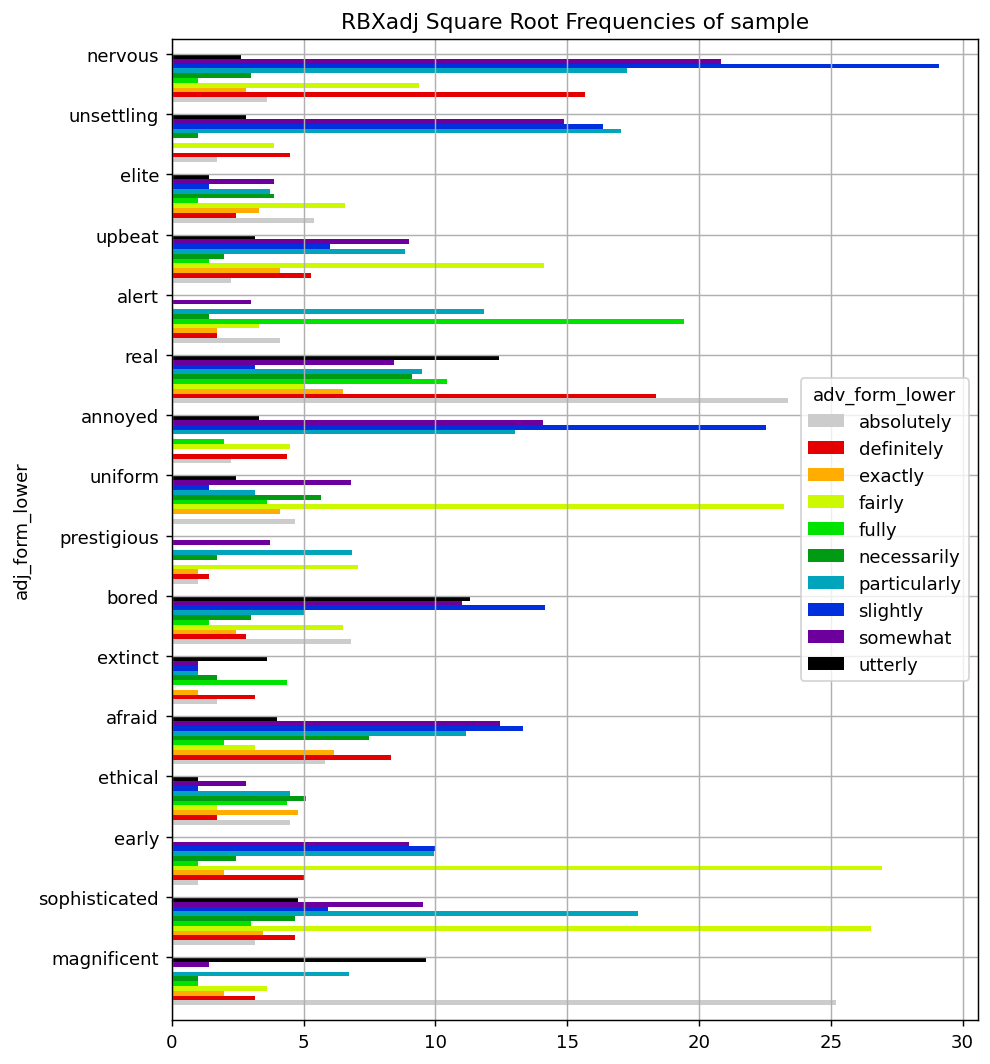

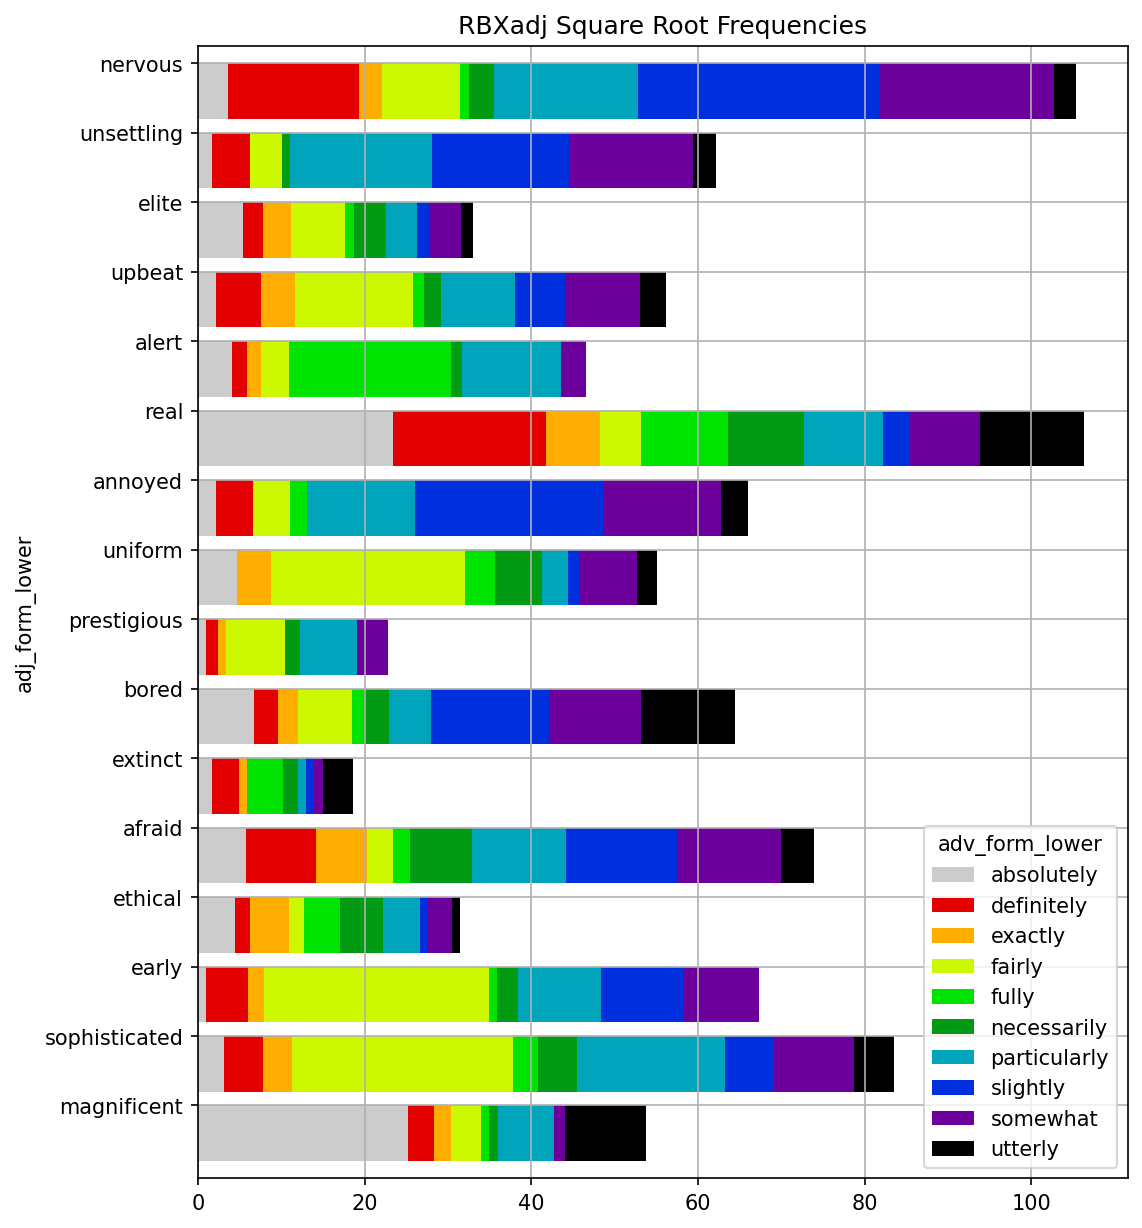

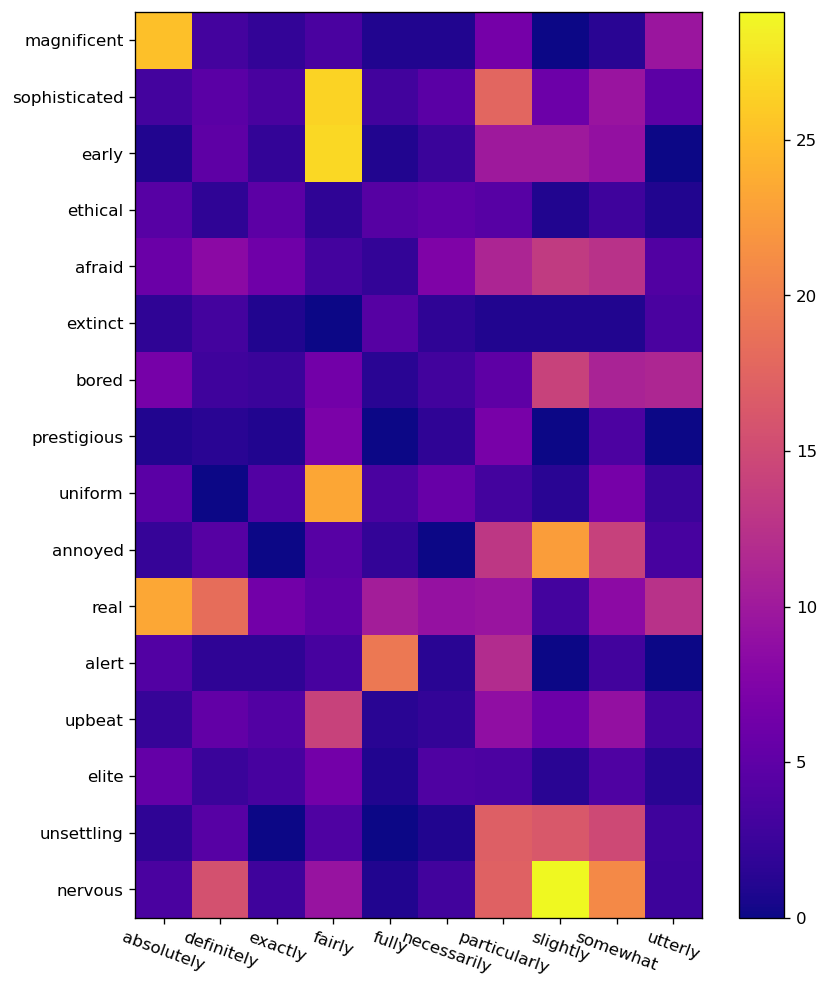

In [151]:
adv_list = ['exactly', 'definitely', 'necessarily','fully', 'fairly', 'somewhat', 'particularly', 'slightly', 'utterly', 'absolutely']
adv_list.sort()

__, sample_all = sample_counts(transform_counts(all_frq), label='RBXadj Square Root Frequencies', columns=adv_list)
# print(sample_all.describe().to_markdown(floatfmt=',.0f'))
adj_list = sample_all.sort_index().index.to_list()

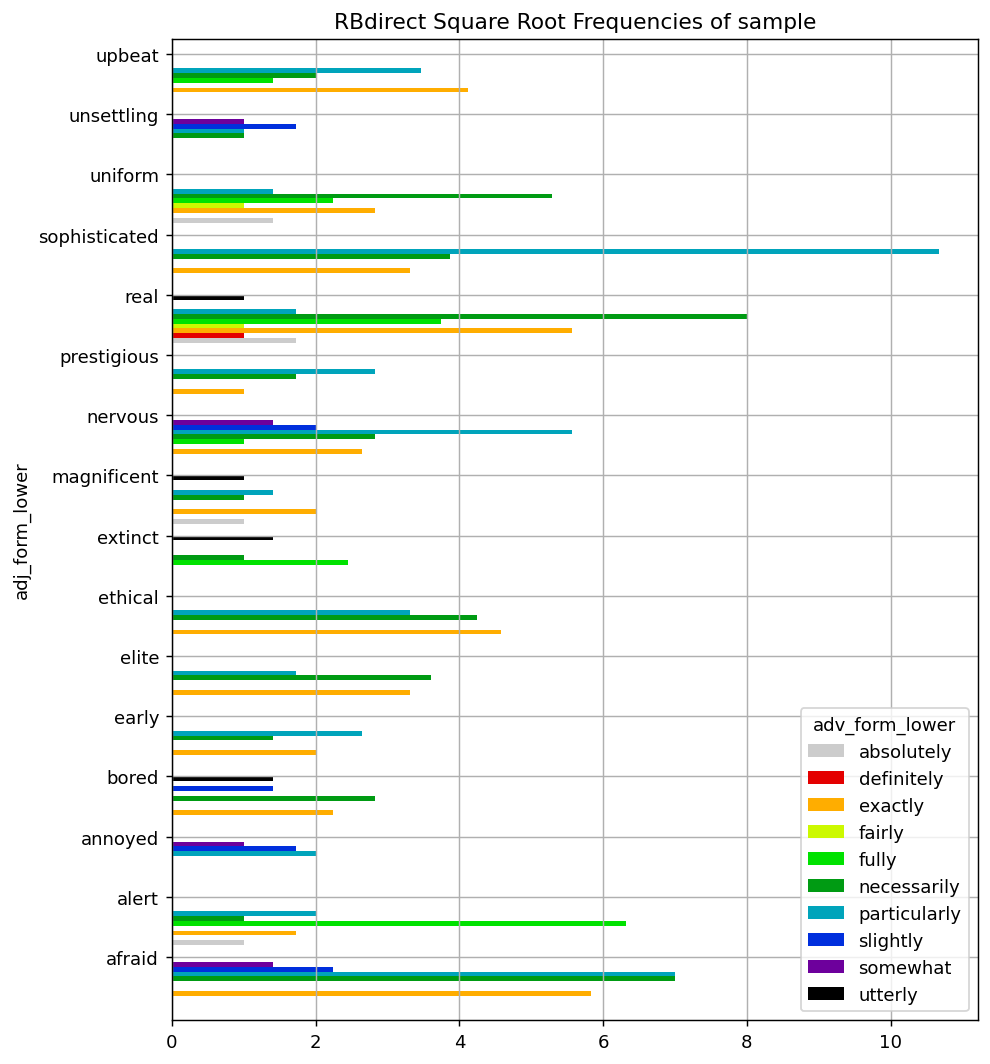

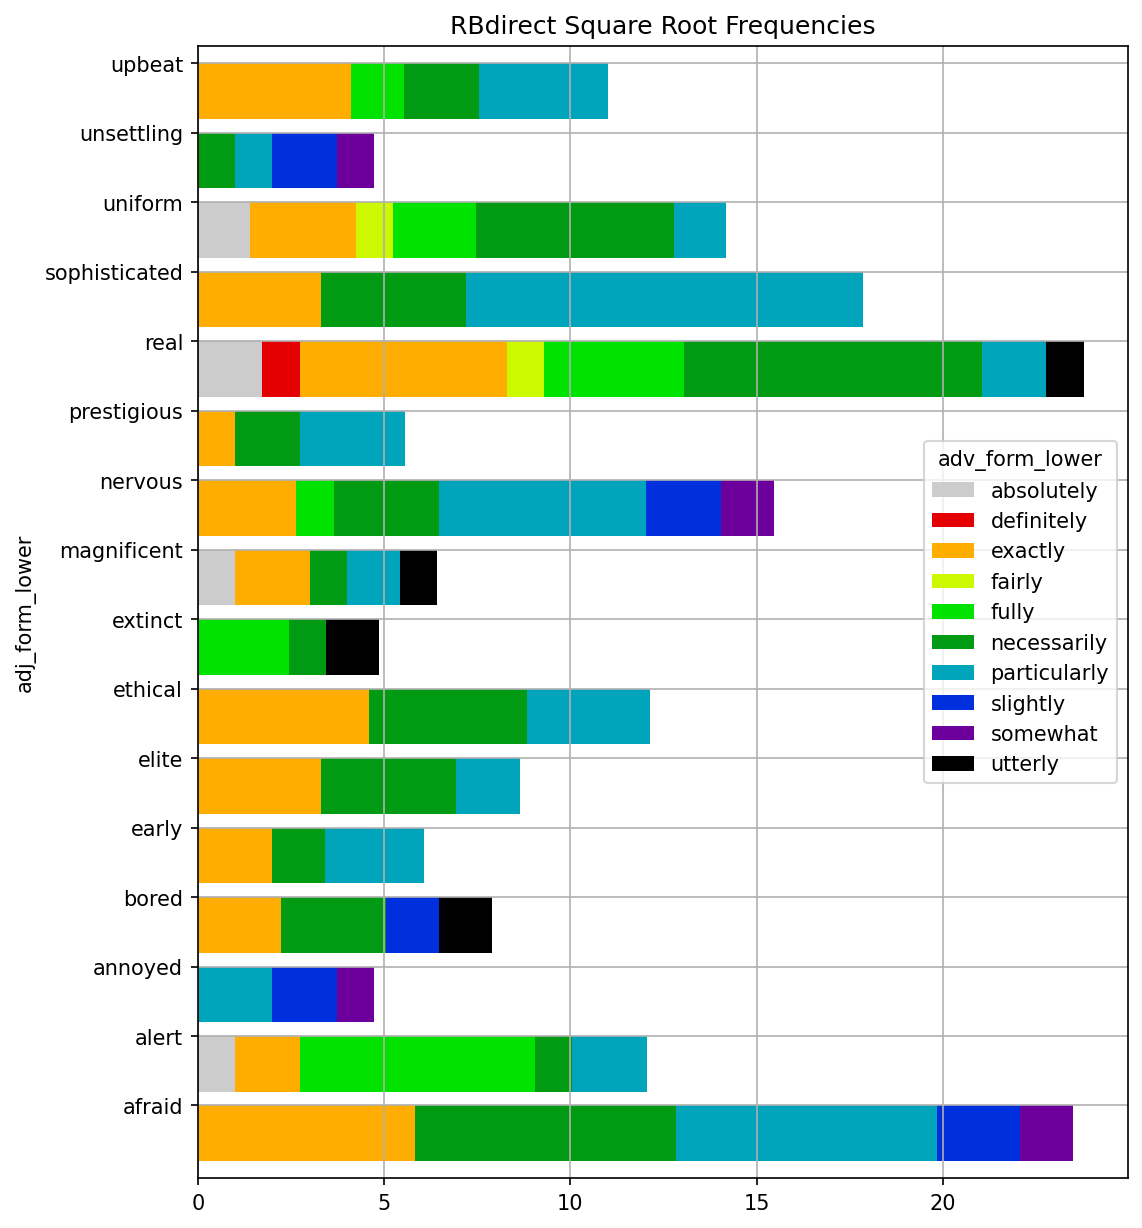

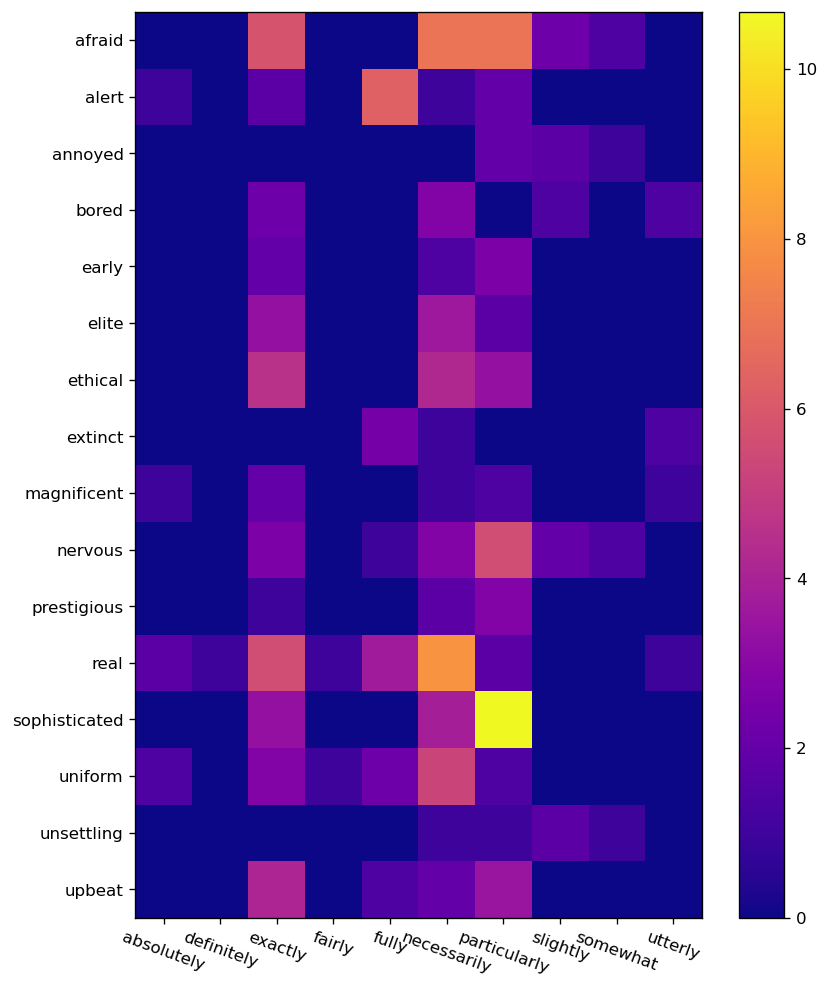

In [152]:
__, sample_neg = sample_counts(transform_counts(neg_frq), 
                               rows=adj_list, 
                               columns=adv_list,
                               label='RBdirect Square Root Frequencies')

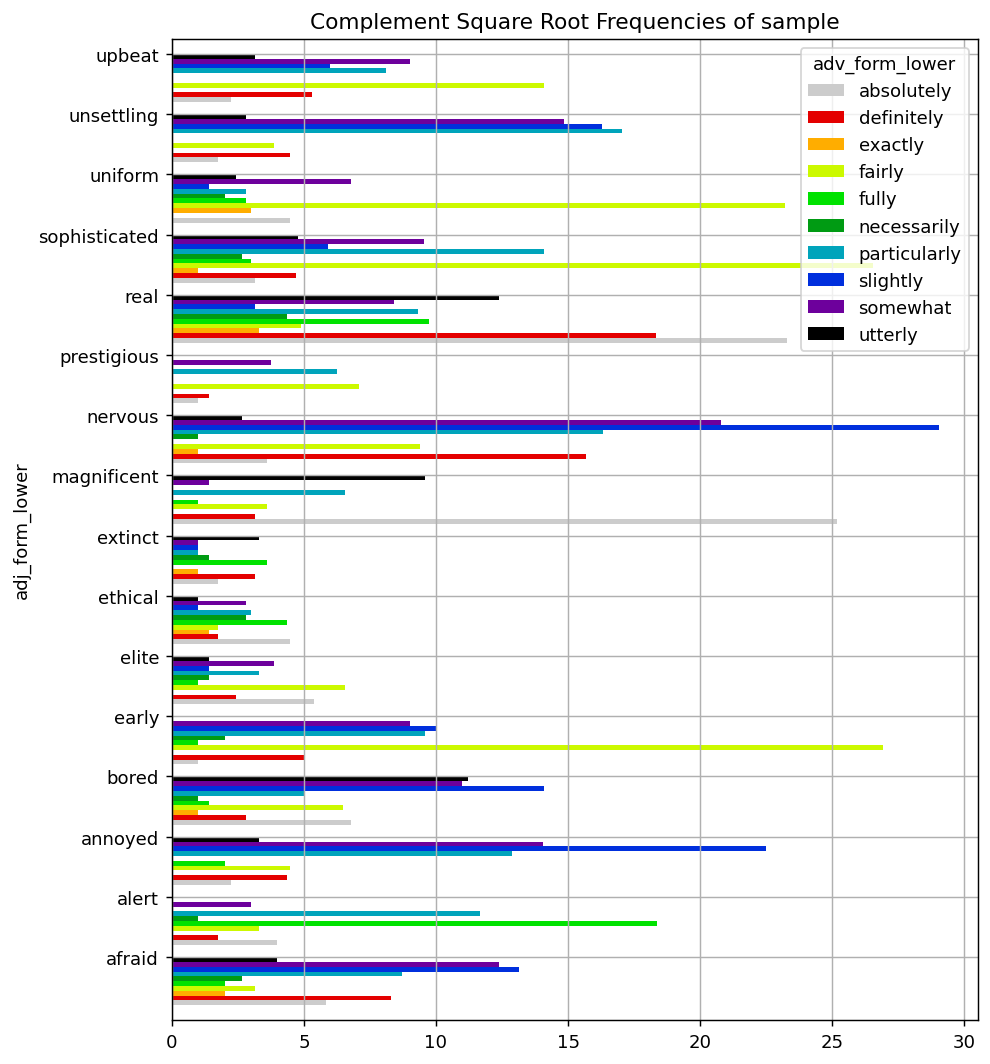

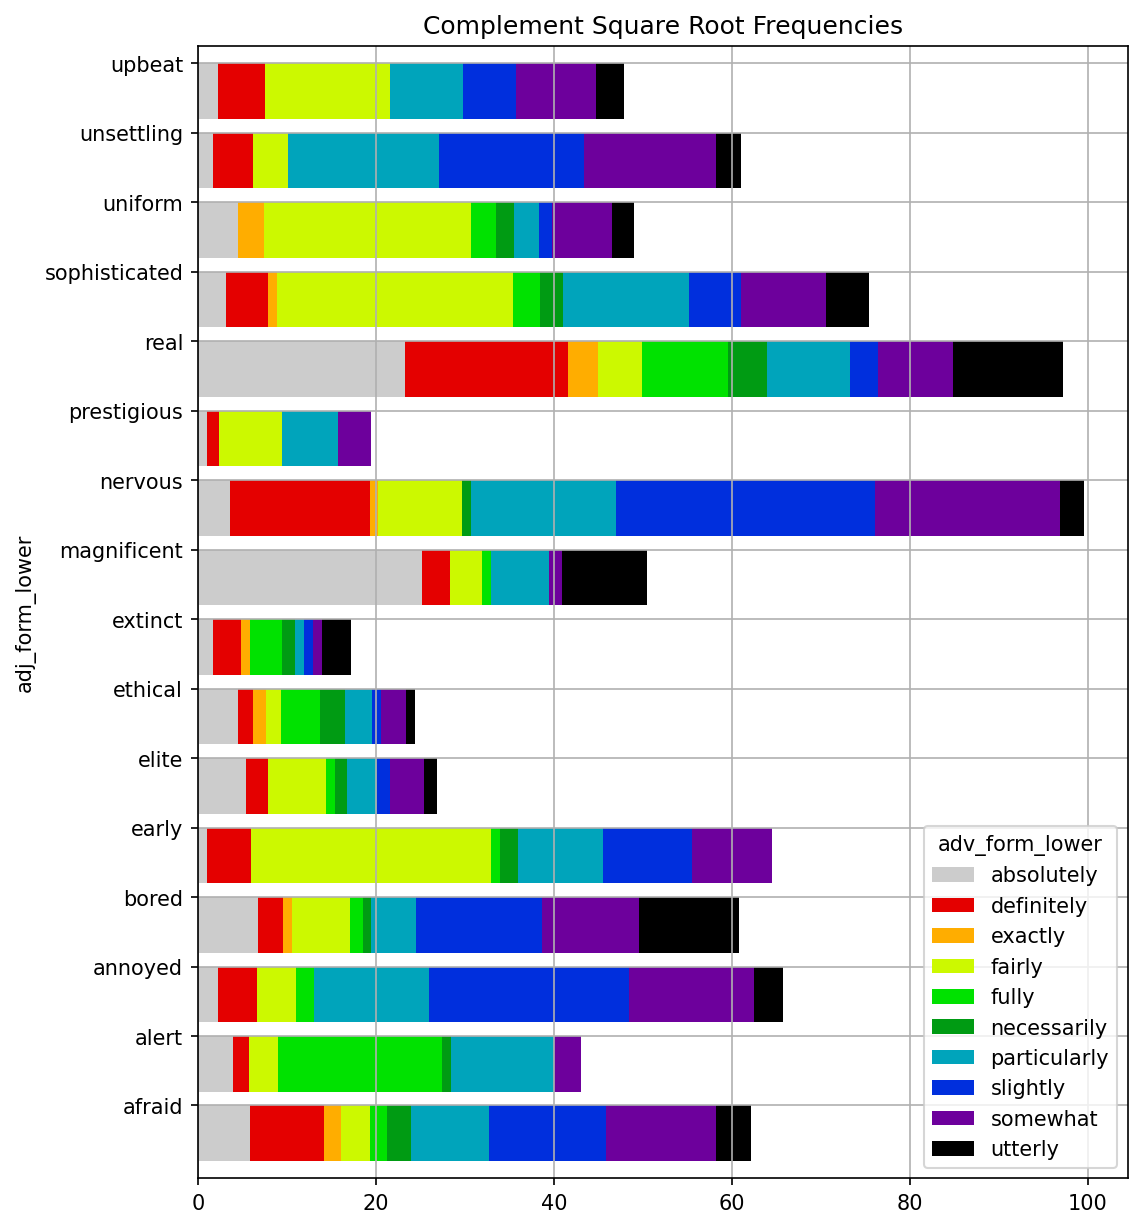

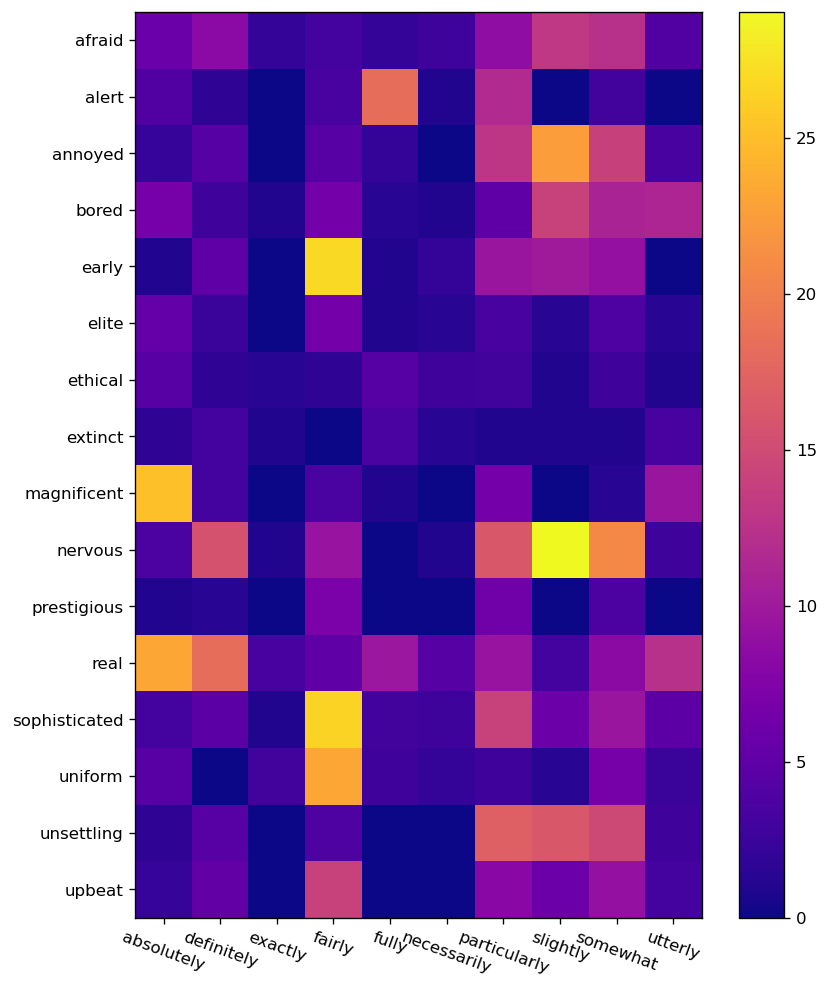

In [153]:
__, sample_diff = sample_counts(transform_counts(frq_diff), 
                               rows=adj_list, 
                               columns=adv_list,
                               label='Complement Square Root Frequencies')

In [154]:
compare_sample = pd.concat([sample_neg.T.add_suffix('-NOT').T, sample_diff]).sort_index()
compare_sample = compare_sample.iloc[:-6, :]

# join(sample_diff).sort_index(axis=1)
print(compare_sample.round(2).to_markdown(floatfmt='.2f'))


| adj_form_lower    |   absolutely |   definitely |   exactly |   fairly |   fully |   necessarily |   particularly |   slightly |   somewhat |   utterly |
|:------------------|-------------:|-------------:|----------:|---------:|--------:|--------------:|---------------:|-----------:|-----------:|----------:|
| afraid            |         5.83 |         8.31 |      2.00 |     3.16 |    2.00 |          2.65 |           8.72 |      13.15 |      12.37 |      4.00 |
| afraid-NOT        |         0.00 |         0.00 |      5.83 |     0.00 |    0.00 |          7.00 |           7.00 |       2.24 |       1.41 |      0.00 |
| alert             |         4.00 |         1.73 |      0.00 |     3.32 |   18.36 |          1.00 |          11.66 |       0.00 |       3.00 |      0.00 |
| alert-NOT         |         1.00 |         0.00 |      1.73 |     0.00 |    6.32 |          1.00 |           2.00 |       0.00 |       0.00 |      0.00 |
| annoyed           |         2.24 |         4.36 |      0.00 | 

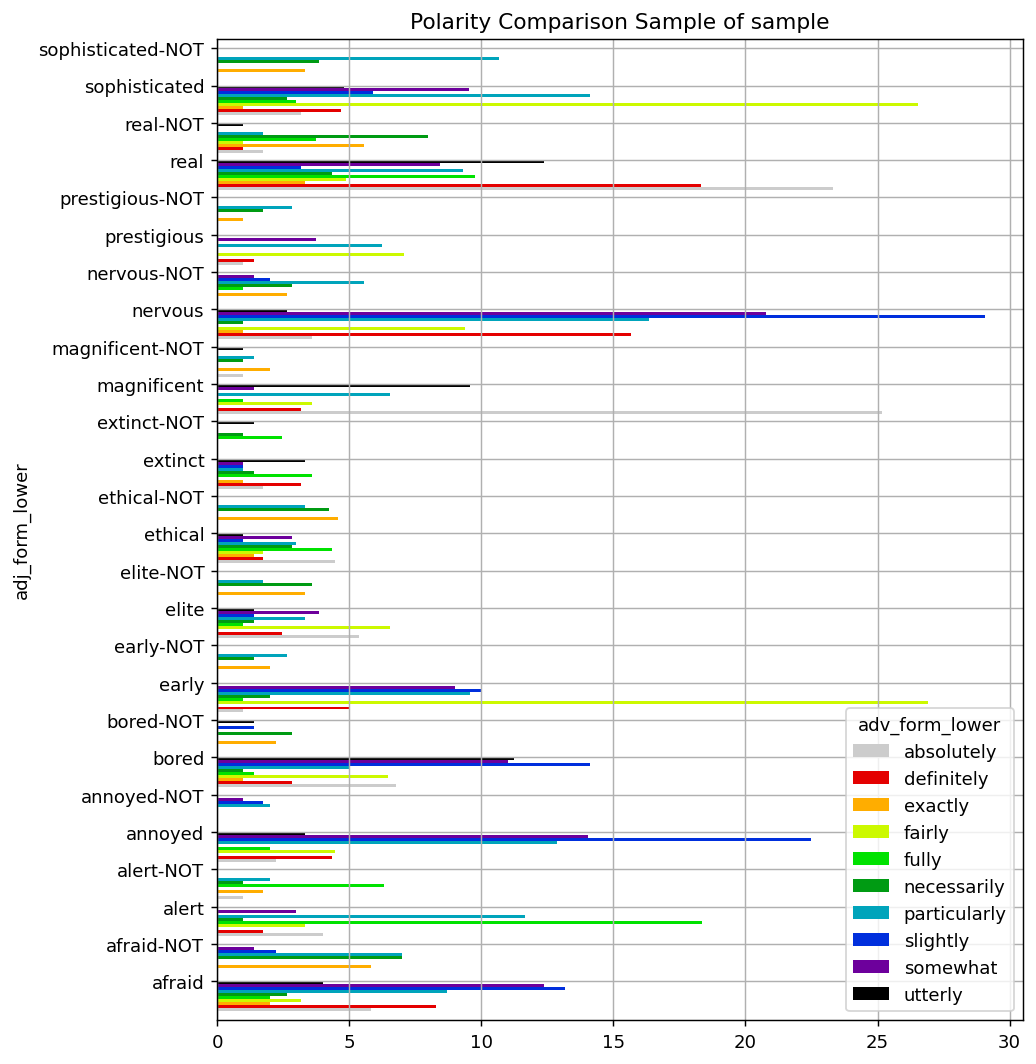

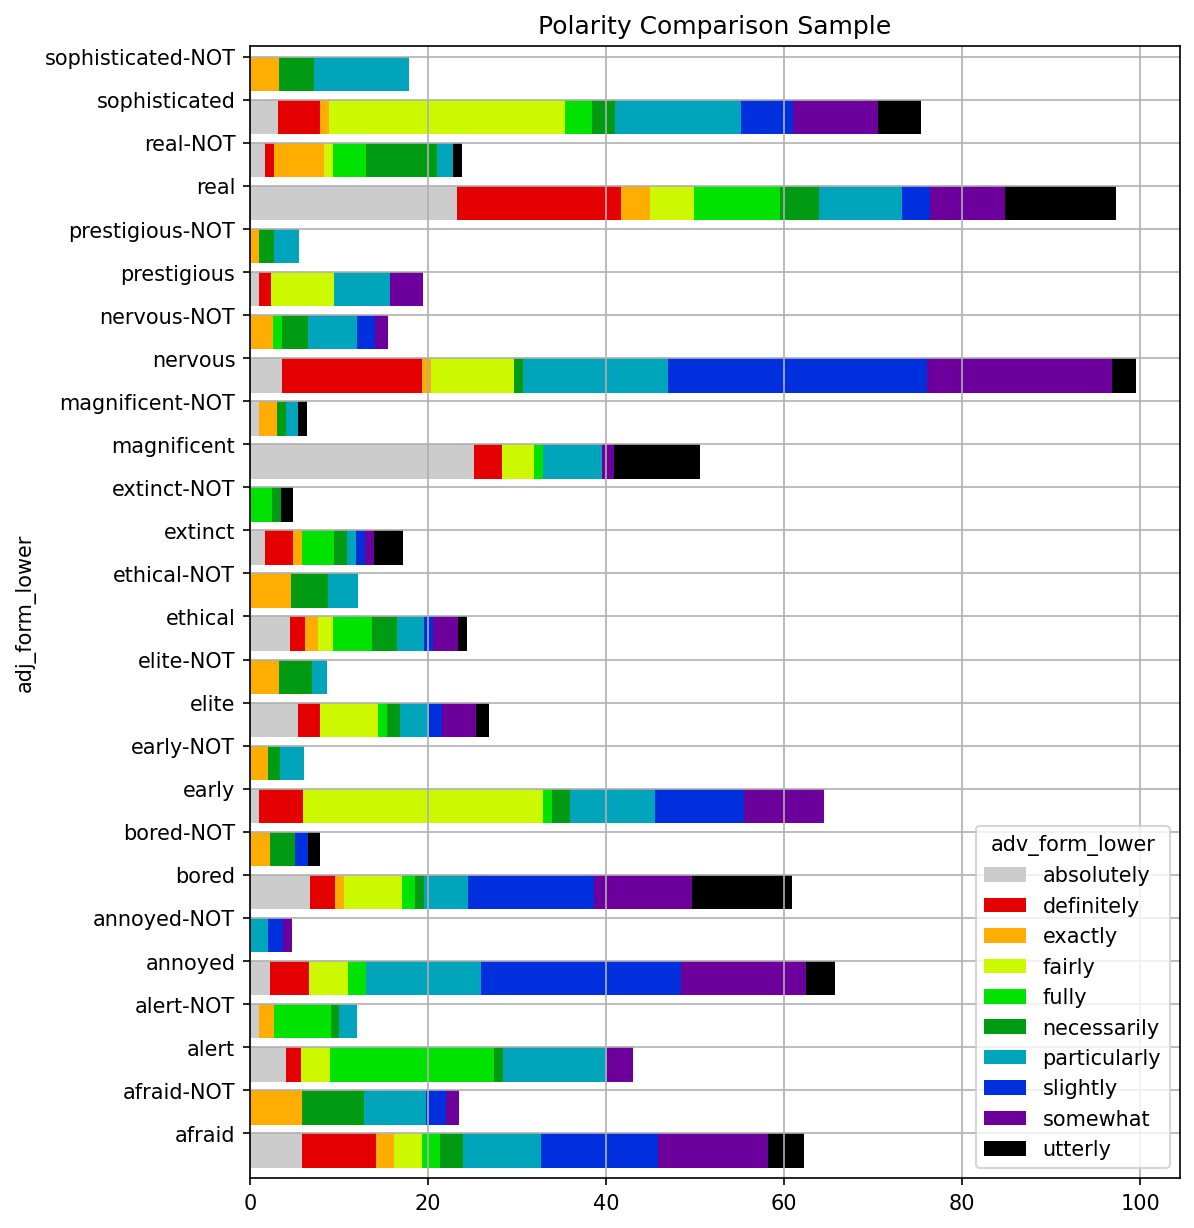

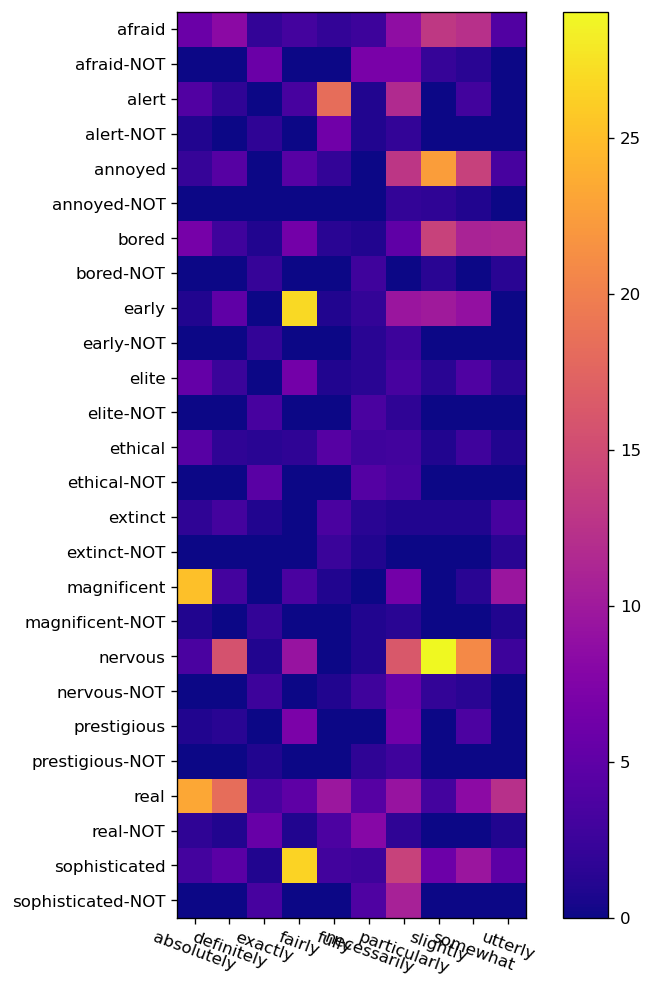

(adv_form_lower     absolutely    definitely    exactly       fairly        \
 adj_form_lower                                                              
 afraid                 5.830952      8.306624      2.000000      3.162278   
 afraid-NOT             0.000000      0.000000      5.830952      0.000000   
 alert                  4.000000      1.732051      0.000000      3.316625   
 alert-NOT              1.000000      0.000000      1.732051      0.000000   
 annoyed                2.236068      4.358899      0.000000      4.472136   
 annoyed-NOT            0.000000      0.000000      0.000000      0.000000   
 bored                  6.782330      2.828427      1.000000      6.480741   
 bored-NOT              0.000000      0.000000      2.236068      0.000000   
 early                  1.000000      5.000000      0.000000     26.925824   
 early-NOT              0.000000      0.000000      2.000000      0.000000   
 elite                  5.385165      2.449490      0.000000    

In [155]:
sample_counts(compare_sample, columns=compare_sample.columns, rows=compare_sample.index, label='Polarity Comparison Sample')

In [156]:
all_frq['ever']

adj_form_lower
SUM           117695
many             206
important        518
good             756
much             156
               ...  
untrained          0
carnal             1
contiguous         0
panicked           0
oversized          0
Name: ever, Length: 3895, dtype: int64

In [157]:
ever=all_frq['ever'].to_frame('ever_ALL').join(pd.to_numeric(frq_diff['ever']).to_frame('ever_DIFF')).join(neg_frq['ever'].to_frame('ever_NEG'))
ever


,ever_ALL,ever_DIFF,ever_NEG
adj_form_lower,,,
SUM,117695,111843,5852
many,206,206,0
important,518,512,6
good,756,423,333
much,156,140,16
...,...,...,...
untrained,0,0,0
carnal,1,1,0
contiguous,0,0,0


In [158]:
ever.ever_DIFF['SUM']/ever.ever_ALL['SUM']

0.9502782616083946

In [159]:
ever.ever_NEG['SUM']/ever.ever_ALL['SUM']

0.04972173839160542

In [160]:
ever_sqrt = transform_counts(ever, 'sqrt').sort_values('ever_NEG', ascending=False)
ever_sqrt.head()

,ever_ALL,ever_DIFF,ever_NEG
adj_form_lower,,,
SUM,343.067049,334.429365,76.498366
easy,25.317978,14.491377,20.760539
good,27.495454,20.566964,18.248288
able,37.389838,34.117444,15.297059
perfect,22.956481,17.606817,14.730920


In [161]:
ever_sqrt.iloc[:, 1:].fillna(0)

,ever_DIFF,ever_NEG
adj_form_lower,,
SUM,334.429365,76.498366
easy,14.491377,20.760539
good,20.566964,18.248288
able,34.117444,15.297059
perfect,17.606817,14.730920
...,...,...
drinkable,0.000000,0.000000
indian,12.328828,0.000000
unremarkable,0.000000,0.000000


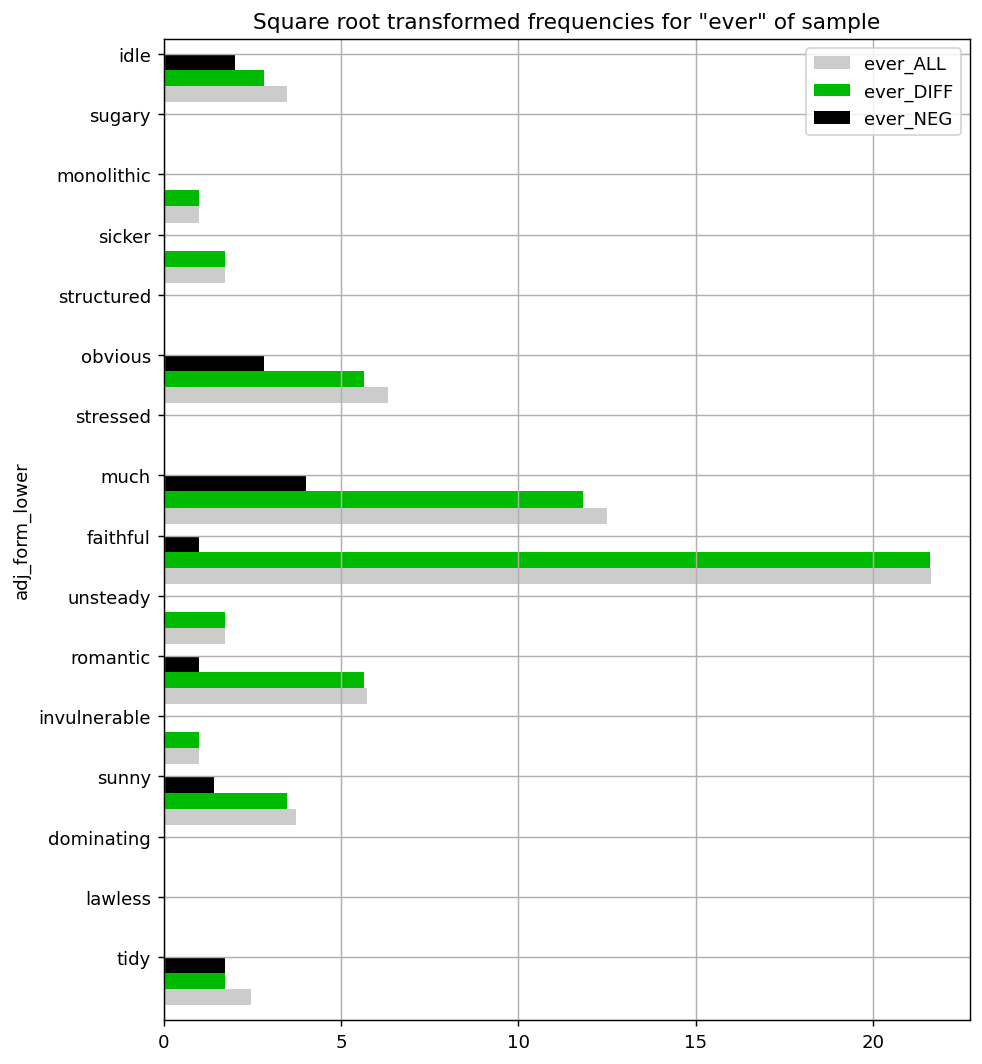

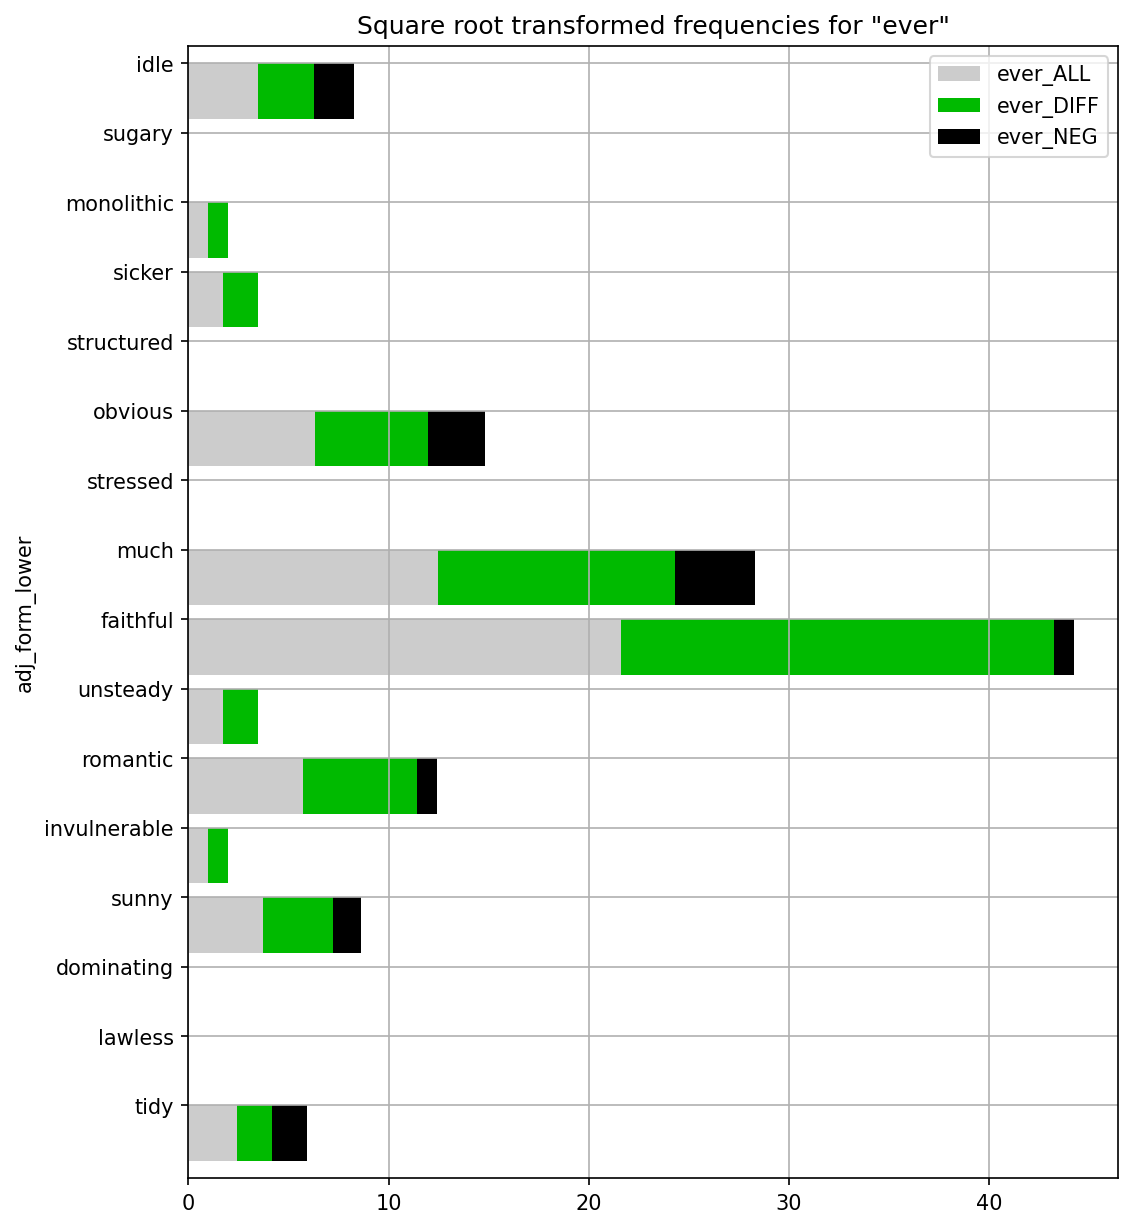

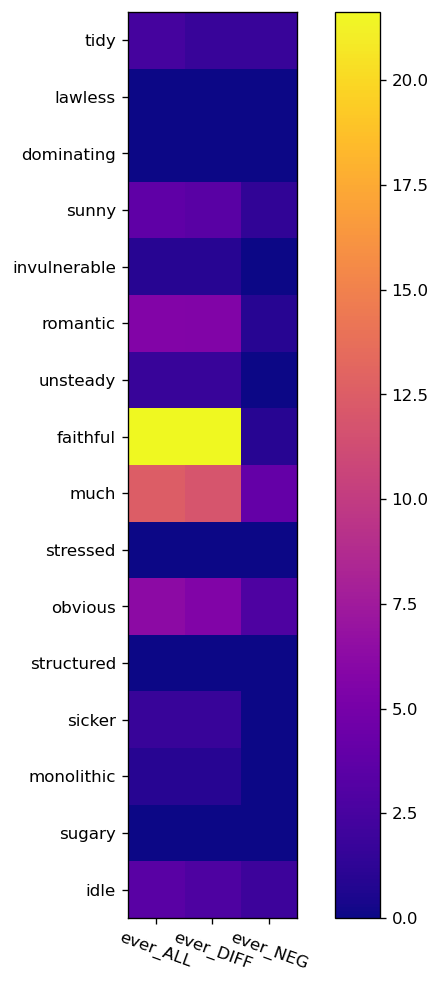

(                 ever_ALL  ever_DIFF   ever_NEG
 adj_form_lower                                 
 likely          44.260592  42.118879  13.601471
 enough          20.124612  15.198684  13.190906
 certain         14.177447   7.348469  12.124356
 wrong           22.494444  19.849433  10.583005
 sure            13.379088   9.591663   9.327379
 ...                   ...        ...        ...
 chummy           0.000000   0.000000   0.000000
 frazzled         0.000000   0.000000   0.000000
 sicker           1.732051   1.732051   0.000000
 unscrupulous     0.000000   0.000000   0.000000
 stalwart         2.645751   2.645751   0.000000
 
 [1553 rows x 3 columns],
                  ever_ALL  ever_DIFF  ever_NEG
 adj_form_lower                                
 tidy             2.449490   1.732051  1.732051
 lawless          0.000000   0.000000  0.000000
 dominating       0.000000   0.000000  0.000000
 sunny            3.741657   3.464102  1.414214
 invulnerable     1.000000   1.000000  0.000000

In [163]:
sample_counts(ever_sqrt, label='Square root transformed frequencies for "ever"', columns=ever_sqrt.columns)
# corners(ever_sqrt.copy().fillna(0), 3)
# sample_counts(ever_sqrt)

### Items that did not appear _with_  direct negation 

= not in negated frequency table, `neg_frq`

(_in this sample_)

In [164]:
def show_items(index_selection, header):
    if any(index_selection):
        print_iter(index_selection, header=header , indent=2)
    else: 
        print(header, ' 🚫 N/A', sep='\n')

In [165]:
adj_never_neg = all_frq.index[~all_frq.index.isin(neg_frq.index)]
show_items(adj_never_neg, header='Adjectives not appearing in negated frequency data')

Adjectives not appearing in negated frequency data
 🚫 N/A


In [166]:
adv_never_neg = all_frq.columns[~all_frq.columns.isin(neg_frq.columns)]
show_items(adv_never_neg, header='Adverbs not appearing in negated frequency data')

Adverbs not appearing in negated frequency data
 🚫 N/A


In [167]:
all_frq.loc[adj_never_neg.to_list() + ['SUM'], adv_never_neg.to_list() + ['SUM']]

adv_form_lower,SUM
adj_form_lower,
SUM,83284343


In [168]:
neg_frq.loc[neg_frq.index.isin(adj_never_neg.to_list() + ['SUM']), neg_frq.columns.isin(adv_never_neg.to_list() + ['SUM'])]

adv_form_lower,SUM
adj_form_lower,
SUM,3151853


### Items that did not appear _without_  direct negation 

= not appearing in the "difference" frequency table, `frq_diff`

#### spoiler: 🚫 There are none.

In [169]:
adj_always_neg =neg_frq.index[~neg_frq.index.isin(frq_diff.index)]
header='Adjectives ONLY appearing in negated frequency data'
show_items(adj_always_neg, header)

Adjectives ONLY appearing in negated frequency data
 🚫 N/A


In [170]:
adv_always_neg = neg_frq.columns[~neg_frq.columns.isin(frq_diff.columns)]
show_items(adv_always_neg, header='Adverbs ONLY appearing in negated frequency data')

Adverbs ONLY appearing in negated frequency data
 🚫 N/A


In [179]:
frq_dfs = {
    'all': all_frq, 
    'neg': neg_frq, 
    'diff': frq_diff}
for name, df in frq_dfs.items():
    print_md_table(sort_by_sum(df).iloc[:19, :13], title=f'#### Top (18 x 12) collocations in {name.upper()} frequencies (+ SUM)')


#### Top (18 x 12) collocations in ALL frequencies (+ SUM)
| adj_form_lower   |        SUM |      very |      more |      most |        so |       not |        as |       too |    really |      much |    pretty |      less |       n't |
|:-----------------|-----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| SUM              | 83,284,343 | 9,913,432 | 9,320,997 | 7,568,812 | 5,735,964 | 4,415,785 | 3,709,914 | 3,557,440 | 2,096,057 | 1,986,728 | 1,621,748 | 1,256,870 | 1,206,294 |
| many             |  2,210,387 |    21,237 |       373 |       140 | 1,191,864 |    58,442 |   434,631 |   450,194 |       518 |       201 |        54 |        54 |       580 |
| important        |  2,199,447 |   359,610 |   306,604 |   748,533 |   105,509 |    17,351 |   102,823 |    12,879 |    72,175 |     1,826 |     6,594 |    25,152 |     7,071 |
| good             |  2,030,480 |   507,499 |    1


#### Top (18 x 12) collocations in ALL frequencies (+ SUM)
| adj_form_lower   |        SUM |      very |      more |      most |        so |       not |        as |       too |    really |      much |    pretty |      less |       n't |
|:-----------------|-----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| SUM              | 83,284,343 | 9,913,432 | 9,320,997 | 7,568,812 | 5,735,964 | 4,415,785 | 3,709,914 | 3,557,440 | 2,096,057 | 1,986,728 | 1,621,748 | 1,256,870 | 1,206,294 |
| many             |  2,210,387 |    21,237 |       373 |       140 | 1,191,864 |    58,442 |   434,631 |   450,194 |       518 |       201 |        54 |        54 |       580 |
| important        |  2,199,447 |   359,610 |   306,604 |   748,533 |   105,509 |    17,351 |   102,823 |    12,879 |    72,175 |     1,826 |     6,594 |    25,152 |     7,071 |
| good             |  2,030,480 |   507,499 |    18,902 |     5,207 |   153,196 |    96,143 |   235,348 |    59,683 |   260,281 |    14,343 |   243,692 |     2,544 |    34,203 |
| much             |  1,776,924 |    42,365 |       102 |        22 |   614,652 |    66,410 |   355,368 |   583,184 |     3,066 |       284 |    57,884 |        15 |    13,683 |
| likely           |  1,048,364 |    35,899 |   498,401 |   192,635 |       847 |    46,858 |    31,820 |     1,196 |       466 |       259 |     1,312 |   139,538 |    17,793 |
| more             |  1,028,133 |        69 |     2,280 |        90 |     2,953 |    17,641 |     2,851 |        52 |     4,561 |   355,655 |        14 |       939 |       696 |
| different        |    906,600 |   233,008 |    12,237 |     1,364 |    39,346 |     4,024 |     9,296 |     5,198 |     6,545 |    44,251 |     2,140 |       198 |       792 |
| available        |    862,942 |       403 |     9,739 |     1,384 |       490 |   132,371 |     1,879 |       277 |       552 |       979 |        32 |     1,978 |    20,868 |
| sure             |    844,066 |     4,691 |     2,324 |       315 |    35,676 |   467,213 |     3,900 |     8,714 |    20,125 |       341 |    84,366 |     2,358 |    92,560 |
| difficult        |    832,988 |   188,193 |   220,215 |    76,638 |    26,542 |    19,841 |    16,041 |    27,938 |    18,779 |       638 |     5,649 |     5,467 |     5,778 |
| popular          |    827,608 |    89,434 |    70,577 |   398,955 |    42,950 |     4,558 |    15,226 |     2,153 |     5,022 |     1,305 |     3,214 |     8,844 |     1,788 |
| easy             |    768,452 |   125,544 |     5,567 |     1,215 |    88,639 |    95,490 |    73,233 |    40,465 |    29,583 |       816 |    31,788 |     1,832 |    37,638 |
| better           |    740,721 |        93 |     1,756 |        66 |       872 |    13,540 |     1,990 |        30 |     1,770 |   295,224 |        16 |        92 |     1,819 |
| high             |    586,188 |   138,155 |     5,218 |    10,402 |    35,697 |     5,769 |    68,042 |    78,087 |    11,041 |       576 |    13,002 |       528 |     2,392 |
| common           |    555,893 |    45,763 |    85,760 |   272,787 |    15,145 |     7,175 |    11,388 |    10,439 |     1,531 |       916 |     7,186 |    16,523 |     1,347 |
| bad              |    554,698 |    50,586 |     8,470 |       703 |    89,547 |    45,132 |    70,769 |    82,159 |    49,477 |     1,675 |    20,388 |     1,743 |    19,968 |
| effective        |    530,361 |    50,857 |   141,978 |   148,925 |    11,156 |     7,561 |    27,812 |       591 |     4,532 |       508 |     2,078 |    17,454 |     2,100 |
| happy            |    526,217 |   143,139 |     5,770 |     2,767 |    79,756 |    47,886 |    11,816 |    16,447 |    37,939 |       547 |    12,490 |     3,130 |    20,152 |

#### Top (18 x 12) collocations in NEG frequencies (+ SUM)
| adj_form_lower   |       SUM |      as |      so |     too |    very |    more |    that |    only |   always |   really |   quite |   even |   entirely |
|:-----------------|----------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|---------:|---------:|--------:|-------:|-----------:|
| SUM              | 3,151,853 | 527,495 | 341,379 | 308,112 | 191,295 | 166,307 | 165,334 | 110,007 |  103,552 |   95,582 |  77,888 | 77,467 |     62,445 |
| good             |   132,519 |  44,998 |  18,026 |   3,631 |  30,415 |      32 |  10,683 |   3,332 |    1,711 |    2,527 |   1,333 |    685 |         89 |
| sure             |   128,813 |     715 |  26,602 |   8,101 |     676 |     142 |     300 |      24 |    1,169 |   17,906 |  26,173 | 14,526 |     13,049 |
| bad              |   105,249 |  27,766 |  21,376 |  19,532 |     317 |       8 |  16,559 |     679 |      916 |      720 |     101 |    111 |        275 |
| easy             |    87,572 |  23,393 |  17,611 |   1,207 |   2,736 |     147 |  10,170 |   1,351 |   24,592 |      544 |     189 |     77 |        107 |
| clear            |    72,890 |   3,462 |   3,257 |     473 |   2,646 |   1,371 |     516 |     111 |    4,024 |    1,500 |   2,310 |  1,615 |      7,531 |
| available        |    55,871 |     321 |      62 |      34 |      27 |      92 |      11 |     570 |    2,361 |      252 |      52 |    789 |         13 |
| important        |    49,973 |  12,307 |   3,415 |     687 |   1,862 |  15,218 |   5,556 |   2,764 |      136 |    1,316 |      37 |    165 |         11 |
| much             |    48,678 |   5,905 |  21,944 |  12,648 |   1,175 |       1 |   4,754 |      38 |       12 |    1,245 |       3 |    189 |          0 |
| different        |    45,681 |     617 |   5,791 |   2,364 |   3,242 |   6,798 |   6,578 |     300 |       14 |      367 |      68 |      6 |        252 |
| great            |    33,068 |   5,739 |   9,605 |   1,296 |     397 |       5 |  11,090 |   1,075 |      614 |      389 |      81 |     29 |         16 |
| big              |    30,884 |  10,776 |   2,115 |   6,442 |   2,466 |       3 |   6,281 |     168 |       57 |      579 |     349 |     92 |          1 |
| hard             |    30,862 |   1,220 |   4,602 |  10,111 |   1,684 |       9 |   9,976 |     314 |       58 |      548 |      41 |    142 |         12 |
| simple           |    30,632 |  14,759 |   6,618 |     237 |     265 |     456 |   6,165 |     263 |      629 |      107 |      77 |      7 |         24 |
| difficult        |    29,909 |   4,638 |   2,611 |   7,449 |   2,442 |   1,700 |   5,583 |     534 |       41 |      305 |      38 |     47 |         29 |
| close            |    29,510 |   2,856 |   1,540 |   1,836 |   1,028 |      14 |     583 |     101 |       56 |      552 |     130 | 17,786 |          5 |
| happy            |    29,367 |   1,765 |   3,083 |   7,363 |   4,442 |   1,151 |     781 |     219 |      628 |    1,402 |     410 |     62 |      1,176 |
| late             |    26,323 |      14 |      83 |  25,876 |      46 |       2 |      13 |      35 |        7 |       20 |       3 |     26 |          0 |
| true             |    25,794 |     444 |     501 |       8 |     101 |   1,970 |     219 |     615 |    2,944 |    1,665 |   1,866 |    526 |      3,672 |

#### Top (18 x 12) collocations in DIFF frequencies (+ SUM)
| adj_form_lower   |        SUM |      very |      more |      most |        so |       not |       too |        as |    really |      much |    pretty |      less |       n't |
|:-----------------|-----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| SUM              | 80,132,490 | 9,722,137 | 9,154,690 | 7,549,126 | 5,394,585 | 4,408,005 | 3,249,328 | 3,182,419 | 2,000,475 | 1,933,499 | 1,619,495 | 1,242,752 | 1,202,442 |
| many             |  2,196,233 |    19,311 |       371 |       140 | 1,189,736 |    58,428 |   444,015 |   431,383 |       498 |       199 |        54 |        53 |       580 |
| important        |  2,149,474 |   357,748 |   291,386 |   747,569 |   102,094 |    17,182 |    12,192 |    90,516 |    70,859 |     1,739 |     6,585 |    24,226 |     6,832 |
| good             |  1,897,961 |   477,084 |    18,870 |     5,202 |   135,170 |    95,797 |    56,052 |   190,350 |   257,754 |    12,877 |   243,508 |     2,519 |    33,848 |
| much             |  1,728,246 |    41,190 |       101 |        22 |   592,708 |    66,385 |   570,536 |   349,463 |     1,821 |       280 |    57,867 |        15 |    13,670 |
| likely           |  1,037,851 |    33,568 |   495,782 |   192,118 |       574 |    46,814 |       899 |    29,733 |       340 |       249 |     1,310 |   139,076 |    17,777 |
| more             |  1,019,610 |        69 |     2,277 |        90 |     2,941 |    17,630 |        51 |     2,841 |     4,466 |   349,068 |        13 |       938 |       693 |
| different        |    860,919 |   229,766 |     5,439 |     1,363 |    33,555 |     4,017 |     2,834 |     8,679 |     6,178 |    33,352 |     2,138 |       193 |       790 |
| popular          |    810,240 |    86,887 |    69,046 |   398,297 |    41,441 |     4,546 |     1,699 |     9,985 |     4,868 |     1,233 |     3,209 |     8,769 |     1,774 |
| available        |    807,071 |       376 |     9,647 |     1,379 |       428 |   132,250 |       243 |     1,558 |       300 |       939 |        31 |     1,975 |    20,814 |
| difficult        |    803,079 |   185,751 |   218,515 |    76,506 |    23,931 |    19,816 |    20,489 |    11,403 |    18,474 |       464 |     5,635 |     5,300 |     5,772 |
| better           |    716,812 |        93 |     1,737 |        66 |       860 |    13,514 |        29 |     1,973 |     1,619 |   283,990 |        15 |        86 |     1,802 |
| sure             |    715,253 |     4,015 |     2,182 |       314 |     9,074 |   466,982 |       613 |     3,185 |     2,219 |       319 |    84,249 |     2,342 |    92,508 |
| easy             |    680,880 |   122,808 |     5,420 |     1,201 |    71,028 |    95,375 |    39,258 |    49,840 |    29,039 |       727 |    31,745 |     1,820 |    37,606 |
| high             |    566,514 |   135,494 |     5,211 |    10,389 |    33,614 |     5,762 |    74,784 |    60,945 |    10,869 |       549 |    12,988 |       525 |     2,389 |
| common           |    544,238 |    43,465 |    85,254 |   272,621 |    13,572 |     7,171 |     9,972 |     7,688 |     1,432 |       901 |     7,176 |    16,500 |     1,343 |
| effective        |    510,206 |    47,718 |   140,448 |   148,430 |    10,661 |     7,538 |       451 |    19,107 |     4,331 |       434 |     2,074 |    17,255 |     2,081 |
| happy            |    496,850 |   138,697 |     4,619 |     2,759 |    76,673 |    47,802 |     9,084 |    10,051 |    36,537 |       503 |    12,481 |     3,087 |    20,113 |
| interesting      |    481,885 |   105,108 |   109,391 |    84,388 |    13,133 |     2,866 |       838 |     5,517 |    42,252 |       762 |    11,917 |     6,464 |     1,470 |


### How about the bigrams considered as a unit?

There are both adverbs and adjectives that didn't make an appearance in the negated data, 
but this could easily be due to the large disparity size of the dataframes. 
So I would be incredibly hesitant to say they are sensitive to polarity (and prefer _positive polarity_). 

Total Tokens per Frequency Group
|      |     totals |
|:-----|-----------:|
| ALL  | 83,284,343 |
| NEG  |  3,151,853 |
| DIFF | 80,132,490 |

Marginal Frequencies for ALL Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,894 |                   1,005 |
| mean  |                  21,388 |                  82,870 |
| std   |                  91,460 |                 581,924 |
| min   |                     870 |                     868 |
| 25%   |                   1,637 |                   1,705 |
| 50%   |                   3,466 |                   4,049 |
| 75%   |                  10,673 |                  15,767 |
| max   |               2,210,387 |               9,913,432 |

Marginal Frequencies for NEG Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,894 |                   1,005 |
| mean  |                     809 |                   3,136 |
| std   |                   4,754 |                  25,306 |
| min   |                       0 |                       0 |
| 25%   |                      35 |                      16 |
| 50%   |                      87 |                      49 |
| 75%   |                     298 |                     206 |
| max   |                 132,519 |                 527,495 |

Marginal Frequencies for DIFF Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,894 |                   1,005 |
| mean  |                  20,578 |                  79,734 |
| std   |                  88,041 |                 566,463 |
| min   |                     801 |                     757 |
| 25%   |                   1,600 |                   1,661 |
| 50%   |                   3,368 |                   3,969 |
| 75%   |                  10,265 |                  15,222 |
| max   |               2,196,233 |               9,722,137 |



In [181]:
totals = pd.Series({name.upper(): frq_df.loc['SUM', 'SUM'] 
                    for name, frq_df in frq_dfs.items()}
                   ).to_frame('totals')
print_md_table(totals, title='Total Tokens per Frequency Group')

for name, neg_frq in frq_dfs.items():
    print_md_table(neg_frq['SUM'].iloc[1:].describe().to_frame('individual adj totals').join(
        neg_frq.T['SUM'].iloc[1:].describe().to_frame('individual adv totals')), 
                   title=f'Marginal Frequencies for {name.upper()} Bigram Tokens')


Total Tokens per Frequency Group
|      |     totals |
|:-----|-----------:|
| ALL  | 83,284,343 |
| NEG  |  3,151,853 |
| DIFF | 80,132,490 |

Marginal Frequencies for ALL Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,894 |                   1,005 |
| mean  |                  21,388 |                  82,870 |
| std   |                  91,460 |                 581,924 |
| min   |                     870 |                     868 |
| 25%   |                   1,637 |                   1,705 |
| 50%   |                   3,466 |                   4,049 |
| 75%   |                  10,673 |                  15,767 |
| max   |               2,210,387 |               9,913,432 |

Marginal Frequencies for NEG Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |               

In [187]:
def get_ratio(df, transpose=False):
    all_vals = all_frq.transpose() if transpose else all_frq
    return df.apply(lambda c: c / all_vals['SUM']).sort_values('SUM', ascending=False).sort_values('SUM',axis=1, ascending=False)

In [188]:
def get_totals_frame(neg_frq, frq_diff, transpose=False):
    if transpose: 
        neg_frq= neg_frq.transpose()
        frq_diff= frq_diff.transpose()
        
    neg_ratio_frq = get_ratio(neg_frq, transpose=transpose)
    diff_ratio_frq = get_ratio(frq_diff, transpose=transpose)

    totals_df=neg_ratio_frq['SUM'].to_frame('NEG/ALL')
    totals_df['DIFF/ALL'] = diff_ratio_frq['SUM']
    totals_df['NEG_RAW'] = neg_frq['SUM']
    totals_df['DIFF_RAW'] = frq_diff['SUM']
    return totals_df

In [189]:
adj_totals = get_totals_frame(neg_frq, frq_diff, transpose=False)
adj_totals.head(15)

,NEG/ALL,DIFF/ALL,NEG_RAW,DIFF_RAW
adj_form_lower,,,,
away,1.000000,1.000000,1291,1291
marrow,1.000000,1.000000,1168,1168
worldwide,1.000000,1.000000,963,963
southerly,1.000000,1.000000,1426,1426
northerly,1.000000,1.000000,1890,1890
earliest,1.000000,1.000000,2199,2199
evolving,1.000000,1.000000,3141,3141
chopped,1.000000,1.000000,1293,1293
later,0.999619,0.999619,2626,2626


In [190]:
adv_totals = get_totals_frame(neg_frq, frq_diff, transpose=True)
adv_totals.head(15)

,NEG/ALL,DIFF/ALL,NEG_RAW,DIFF_RAW
adv_form_lower,,,,
legendarily,1.000000,1.000000,981,981
yearly,1.000000,1.000000,2218,2218
sparsely,1.000000,1.000000,1281,1281
second-most,1.000000,1.000000,869,869
albeit,0.999810,0.999810,15764,15764
preferably,0.999757,0.999757,4110,4110
alternately,0.999721,0.999721,3588,3588
increasingly,0.999595,0.999595,390385,390385
unseasonably,0.999510,0.999510,2038,2038


In [193]:
print(all_frq.loc[frq_diff.min(axis=1) ==-2, frq_diff.min() ==-2].join(
    neg_frq.loc[frq_diff.min(axis=1) ==-2, frq_diff.min() ==-2], rsuffix='_neg').join(
    frq_diff.loc[frq_diff.min(axis=1) ==-2, frq_diff.min() ==-2], rsuffix='_diff').to_markdown(floatfmt=',.0f'))

| adj_form_lower   |
|------------------|



### ⚠️ RBdirect double-dipping

The `frq_diff` dataframe contains negative values because there are certain bigrams are flagged multiple times by the negation patterns.

That is, there are multiple `NEG` nodes in the parse with a direct tie to `ADJ`. They are not both _valid_,
but at the current time (Dec 7, 2023) no checks are in place to select the appropriate hit.
Which negation is selected is probably not a huge deal, since, if the different `NEG` nodes have the same case-normalized form,
they are identical in regards to the basic frequency tables. 
(It matters more if more specific `dep_str*` values are used, especially if the relation type differs as well.)


### ❗ For now, `RBdirect` frequencies will be overriden manually
but this needs to be addressed. There is no telling how many such cases there are---I'm 
lucky that there were some relevant bigrams with counts low enough to throw an error



- [ ] add code to import `transform_counts` using `sqrt`